In [43]:
import calfem.geometry as cfg
import calfem.mesh as cfm
import calfem.vis as cfv
import calfem.vis_mpl as cfvl
import numpy as np
from numba import njit

def mean_square(coords, polygons):
    
    S_el = lambda poly: ((coords[poly[1] - 1][0] - coords[poly[0] - 1][0]) * (coords[poly[2] - 1][1] - coords[poly[0] - 1][1]) - (coords[poly[2] - 1][0] - coords[poly[0] - 1][0]) * (coords[poly[1] - 1][1] - coords[poly[0] - 1][1])) / 2
    res = 0.
    for el in polygons:
        res += S_el(el)
    return round(res / len(polygons), 8)

def max_square(coords, polygons):
    
    S_el = lambda poly: ((coords[poly[1] - 1][0] - coords[poly[0] - 1][0]) * (coords[poly[2] - 1][1] - coords[poly[0] - 1][1]) - (coords[poly[2] - 1][0] - coords[poly[0] - 1][0]) * (coords[poly[1] - 1][1] - coords[poly[0] - 1][1])) / 2
    S_max = 0.
    tmp = 0.
    for el in polygons:
        tmp = S_el(el)
        if (tmp > S_max):
            S_max = tmp
    return round(S_max, 8)

### Define Geometry

In [19]:
point_co_arr = [[0., 0.], [0.22055117451721412, 0.33955239167528295], [0.32412393069948864, 0.4874201143956197], [0.4104847072310811, 0.6010289122140435], [0.4881128059494951, 0.6937809302033444], [0.6320772802621745, 0.8375943615288411], [0.7625718281066655, 0.9312560510634783], [0.8848733016097592, 0.9836928538590948], [1.000000000000005, 1.], [1.1207883485437105, 0.982054456792746], [1.2426753444628058, 0.9282212659225965], [1.3680453072991685, 0.8374891518337156], [1.5000284665069992, 0.7070751621400859], [1.643661767205692, 0.5309614763164495], [1.8094003453508183, 0.29494048985621424], [2.031763994313858, -0.049874066102280075], [2.2640781032737243, -0.40301871843627207], [2.3590291919467576, -0.5345386215772783], [2.4412011973914924, -0.6388766866952208], [2.515937865915456, -0.72458586923369], [2.654668064546828, -0.8564484701133004], [2.7806792446429136, -0.9412416514540224], [2.8964596449755358, -0.9868031124580505], [2.999999980154588, -0.9999999999999996], [3.114326342360129, -0.9839181913742655], [3.235656714482532, -0.9322663272756924], [3.359892702133432, -0.8444182234155081], [3.489592594181542, -0.7185715011647854], [3.628532838164962, -0.5509475703249581], [3.784040275696842, -0.3327598856393173], [4., 0.], [0., 0.3333333333333333], [0., 0.6666666666666666], [0., 1.], [0., 1.3333333333333333], [0., 1.6666666666666665], [0., 2.], [4., 0.33333333333331616], [4., 0.666666666666653], [4., 0.9999999999999898], [4., 1.3333333333333266], [4., 1.6666666666666634], [4., 2.], [0.4, 2.], [0.8, 2.], [1.2000000000000002, 2.], [1.6, 2.], [2., 2.], [2.4000000000000004, 2.], [2.8000000000000003, 2.], [3.2, 2.], [3.6, 2.]]
point_pol_arr = [[1, 2], [32, 1], [47, 46], [33, 32], [3, 4], [2, 3], [36, 35], [4, 5], [39, 40], [12, 13], [34, 33], [10, 11], [46, 45], [6, 7], [35, 34], [41, 42], [44, 37], [37, 36], [7, 8], [29, 30], [9, 10], [11, 12], [8, 9], [5, 6], [45, 44], [21, 22], [15, 16], [19, 20], [18, 19], [22, 23], [24, 25], [30, 31], [25, 26], [27, 28], [20, 21], [16, 17], [26, 27], [23, 24], [51, 50], [49, 48], [40, 41], [50, 49], [17, 18], [31, 38], [42, 43], [43, 52], [13, 14], [38, 39], [48, 47], [28, 29], [14, 15], [52, 51]]


In [47]:
g = cfg.Geometry()

g.point([0.0, 1.0]) # point 0
g.point([1.0, 0.0]) # point 0
g.point([2.0, 1.0]) # point 1

g.point([2.0, 2.0]) # point 1
g.point([0.0, 2.0]) # point 1

# g.point([3.0, 0.0]) # point 1
# g.point([4.0, 1.0]) # point 2
# g.point([4.0, 2.0]) # point 2
# g.point([0.0, 2.0]) # point 2


# g.point([5.0, 0.0]) 
# g.point([6.0, 1.0]) 
# g.point([6.0, 2.0]) 
# g.point([0.0, 2.0]) 


g.spline([0, 1], marker=10) # line 0
g.spline([1, 2], marker=10) # line 1
g.spline([2, 3], marker=10) # line 2
g.spline([3, 4], marker=10) # line 3
g.spline([4, 0], marker=10) # line 3


# g.spline([5, 6], marker=10) # line 3
# g.spline([6, 7], marker=0) # line 3
# g.spline([7, 8], marker=0) # line 3
# g.spline([8, 0], marker=0) # line 3


g.surface([0, 1, 2, 3, 4 ]) #, 5, 6, 7, 8])


### Generate Mesh

In [48]:
def reshape_boundary_dict(bdofs):
    nodeset = set([0])
    for array in bdofs.items():
        nodeset.update(array[1])
    new = np.zeros(len(nodeset)-1)
    for key in bdofs:
        for elem in bdofs[key]:
            new[elem-1] = key
    return new

In [49]:
mesh = cfm.GmshMesh(g)
mesh.elType = 2          # Degrees of freedom per node.
mesh.dofsPerNode = 1     # Factor that changes element sizes.
mesh.elSizeFactor = 0.1425 # Element size Factor 
"""
    mesh.elSizeFactor = 0.3325  ~   max S_el = 0.05
    mesh.elSizeFactor = 0.1425  ~   max S_el = 0.01
    mesh.elSizeFactor = 0.042   ~   max S_el = 0.001
    0.029 ~ 0.0005
"""
coords, edof, dofs, bdofs, elementmarkers = mesh.create()

print("mean: ", mean_square(coords, edof))
print("max: ", max_square(coords, edof))
boundary_voltages = reshape_boundary_dict(bdofs)
print(boundary_voltages)

Info    : GMSH -> Python-module
Info    : Reading '/tmp/tmp93ivnd2c/tempGeometry.geo'...
Info    : Done reading '/tmp/tmp93ivnd2c/tempGeometry.geo'
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Nurb)
Info    : [ 20%] Meshing curve 2 (Nurb)
Info    : [ 40%] Meshing curve 3 (Nurb)
Info    : [ 60%] Meshing curve 4 (Nurb)
Info    : [ 80%] Meshing curve 5 (Nurb)
Info    : Done meshing 1D (Wall 0.000398376s, CPU 0.000445s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.00465468s, CPU 0.004963s)
Info    : 227 nodes 457 elements
Info    : Writing '/tmp/tmp93ivnd2c/meshFile.msh'...
Info    : Done writing '/tmp/tmp93ivnd2c/meshFile.msh'
mean:  0.0074813
max:  0.01082481
[10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.]


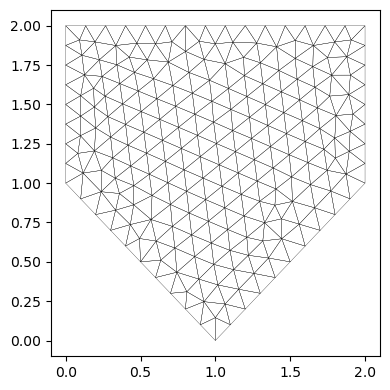

In [52]:
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import pandas as pd
import numpy as np
from numba import njit
import time

def plot_fem_mesh(nodes, elements, linewidth: float = 0.2):

    plt.rcParams["figure.figsize"] = [4, 4]
    plt.rcParams["figure.autolayout"] = True
    it = 0
    for element in elements:
        x = [nodes[element[0] - 1][0], nodes[element[1] - 1][0], nodes[element[2] - 1][0]]
        y = [nodes[element[0] - 1][1], nodes[element[1] - 1][1], nodes[element[2] - 1][1]]
        plt.fill(x, y, edgecolor='black', linewidth = linewidth, fill=False)
        it += 1


plot_fem_mesh(coords, edof)

In [56]:
for i in reversed(range(44, 51)):
    print(f"""{2.0}, {coords[i][1]}""")

# print(f"""x,y""")
# for i in coords:
#     print(f"""{i[0]}, {i[1]}""")

2.0, 1.124999999138059
2.0, 1.24999999838454
2.0, 1.374999998346593
2.0, 1.499999998200225
2.0, 1.624999998487539
2.0, 1.749999999121797
2.0, 1.874999999929527


In [54]:
print(f"""p1,p2,p3""")
for i in edof:
    print(f"""{i[0]}, {i[1]}, {i[2]}""")

p1,p2,p3
60, 23, 70
6, 62, 117
60, 70, 71
152, 58, 167
72, 74, 168
151, 63, 190
63, 151, 198
58, 165, 167
117, 62, 201
68, 151, 190
151, 68, 209
117, 166, 207
52, 147, 213
150, 65, 152
166, 117, 201
69, 178, 211
196, 36, 213
119, 72, 168
21, 22, 119
147, 52, 192
74, 107, 168
178, 133, 211
1, 6, 117
23, 3, 70
21, 119, 123
156, 63, 198
149, 196, 213
152, 65, 202
147, 149, 213
118, 53, 200
63, 156, 206
56, 163, 208
163, 56, 204
53, 118, 220
160, 148, 162
122, 195, 197
10, 125, 222
164, 39, 208
39, 164, 210
120, 59, 122
148, 160, 184
58, 152, 202
22, 60, 119
125, 10, 205
160, 159, 184
59, 120, 124
195, 122, 216
165, 58, 196
170, 54, 222
60, 71, 72
53, 20, 123
20, 21, 123
67, 172, 197
131, 161, 163
162, 148, 192
105, 111, 124
120, 105, 124
148, 147, 192
55, 156, 215
159, 92, 184
197, 172, 203
153, 92, 182
156, 55, 206
155, 154, 156
126, 96, 127
135, 115, 154
95, 96, 126
62, 7, 134
68, 193, 209
161, 131, 173
136, 154, 155
73, 115, 135
127, 132, 157
123, 119, 168
124, 111, 125
125, 170, 222
1

### Assemble Element Matrices

In [26]:
def Ke(coords, alpha_x, alpha_y):
    x1 = coords[0,0]
    x2 = coords[1,0]
    x3 = coords[2,0]
    y1 = coords[0,1]
    y2 = coords[1,1]
    y3 = coords[2,1]
    A = 1/2 * np.abs(x1*(y2 - y3) + x2 * (y3 - y1) + x3 * (y1 - y2))
    M11 = -(alpha_x * (y2 - y3) ** 2  + alpha_y * (x3 - x2) ** 2) / (4 * A)
    M12 = -(alpha_x * (y2 - y3) * (y3 - y1) + alpha_y * (x3 - x2) * (x1 - x3)) / (4 * A)
    M13 = -(alpha_x * (y2 - y3) * (y1 - y2) + alpha_y * (x3 - x2) * (x2 - x1)) / (4 * A)
    M22 = -(alpha_x * (y3 - y1) ** 2 + alpha_y * (x1 - x3) ** 2) / (4 * A)
    M23 = -(alpha_x * (y3 - y1) * (y1 - y2) + alpha_y * (x1 - x3) * (x2 - x1)) / (4 * A)
    M33 = -(alpha_x * (y1 - y2) ** 2 + alpha_y * (x2 - x1) ** 2) / (4 * A)
    return np.matrix(
        [
            [M11, M12, M13],
            [M12, M22, M23],
            [M13, M23, M33]
        ])

In [27]:
# import pandas as pd
# df_x_y = pd.read_csv("./domains/domain_2/mesh0005_test/mesh_nodes.csv")
# df_z = pd.read_csv("./output/domain_2_extra/mesh0005_test/Test_domain_2_rectangle_dirichlet_only_0005_test_solution.csv")
# df_elements = pd.read_csv("./domains/domain_2/mesh0005_test/mesh_polygons.csv")
# co = coords.copy()
# for i in range(len(df_x_y["x"].values)):
#     co[i][0] = df_x_y["x"].values[i]
#     co[i][1] = df_x_y["y"].values[i]

num_elem = len(edof)
num_nodes = len(dofs)

ke = np.zeros((num_elem, 3, 3))

for i in range(num_elem):
    ke[i] = Ke(coords[edof[i] - 1], 1, 1)


### Assemble Global Matrix

In [28]:
K = np.zeros((num_nodes, num_nodes))
for e in range(num_elem):
    for i in range(3):
        for j in range(3):
            K[edof[e,i] - 1, edof[e,j] - 1] += ke[e,i,j]

### Create RHS Vector

In [29]:
b = np.zeros(num_nodes)

### Introduce Boundary Conditions

In [30]:
for n in reversed (range(len(boundary_voltages))):
    for i in range(len(b)):
        if np.fabs(boundary_voltages[n]) > 1e-16:
            b[i] -= boundary_voltages[n]*K[i, n]
    b = np.delete(b, n, axis=0)
    K = np.delete(K, n, axis=0)
    K = np.delete(K, n, axis=1)

### Solve

In [31]:
x = np.linalg.solve(K,b)
v = np.zeros(num_nodes-len(x))
v = np.concatenate((boundary_voltages,x))

### Plot

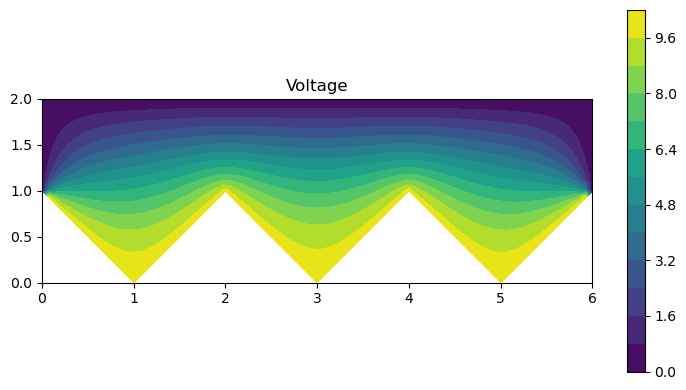

In [32]:
cfvl.figure(fig_size=(7.5, 4))
cfvl.draw_nodal_values_contourf(v, coords, edof, title="Voltage", dofs_per_node=mesh.dofs_per_node, el_type=mesh.el_type, draw_elements=False)
cfvl.colorbar()